# Introduction

This notebook demonstrates how we can make use of DBSCAN for properly clustering clusters of arbitrary shapes and varying densities, which is not achievable by using conventional clustering methods, such as K-Means and Hierarchical clustering.

# Import required libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math

sns.set_style('whitegrid')

# Create the dataset

In [2]:
np.random.seed(42)

# Function for creating datapoints in the form of a circle
def PointsInCircum(r,n=100):
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-30,30),math.sin(2*math.pi/n*x)*r+np.random.normal(-30,30)) for x in range(1,n+1)]

In [3]:
# Creating data points in the form of a circle
df=pd.DataFrame(PointsInCircum(500,1000))
df=df.append(PointsInCircum(300,700))
df=df.append(PointsInCircum(100,300))

# Adding noise to the dataset
df=df.append([(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)])

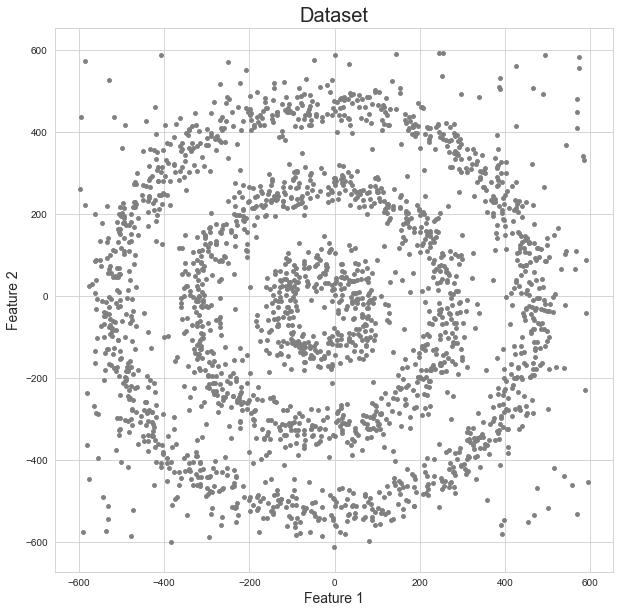

In [4]:
# Plot the scatter plot of the generated dataset
plt.figure(figsize=(10,10))
plt.scatter(df[0],df[1],s=15,color='grey')
plt.title('Dataset',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

From the scatter plot above, we can clearly see that there are 3 clusters which are in the form of concentric circles with some noise. Let's try if this 3 clusters can be identified using K-Means, Hierarchical and DBSCAN clustering algorithms.

# K-Means vs. Hierarchical vs. DBSCAN Clustering

# Clustering using K-Means:

In [5]:
from sklearn.cluster import KMeans
k_means=KMeans(n_clusters=3,random_state=42)
k_means.fit(df[[0,1]])

KMeans(n_clusters=3, random_state=42)

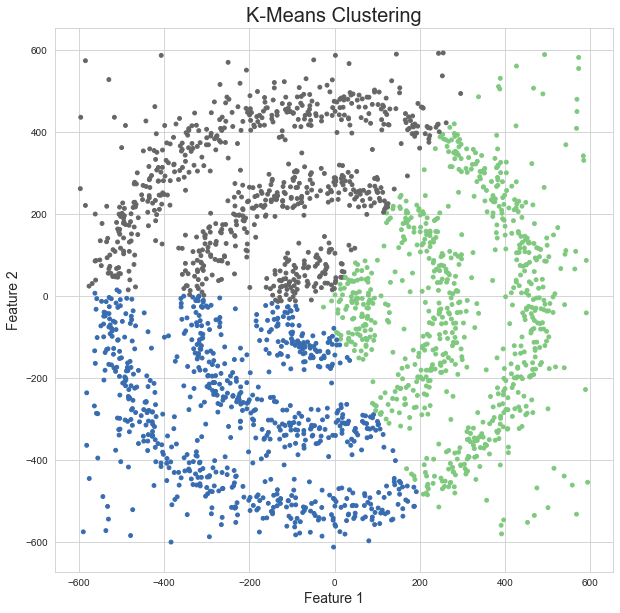

In [6]:
df['KMeans_labels']=k_means.labels_

# Plotting resulting clusters
plt.figure(figsize=(10,10))
plt.scatter(df[0],df[1],c=df['KMeans_labels'], cmap = 'Accent',s=15)
plt.title('K-Means Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

From the visualization above, we can see that K-Means clustering is not able to correctly cluster the 3 concentric groups. Now, let's try Hierarchical clustering.

# Clustering using Hierarchical:

In [7]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
model.fit(df[[0,1]])

AgglomerativeClustering(n_clusters=3)

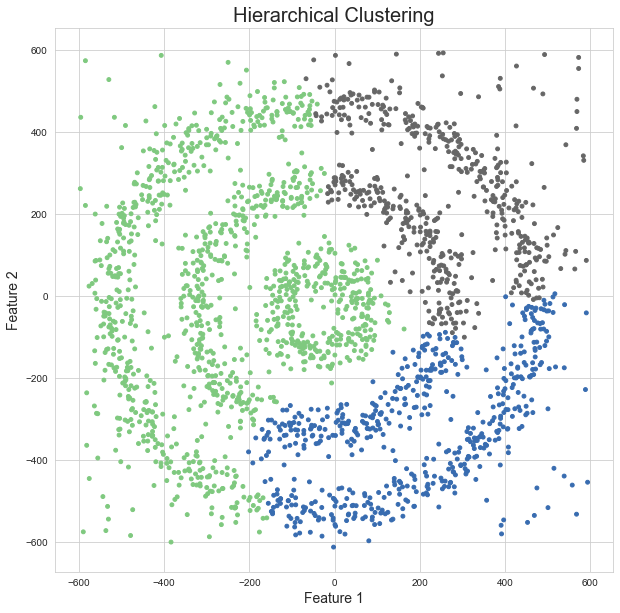

In [8]:
df['HR_labels']=model.labels_

# Plotting resulting clusters
plt.figure(figsize=(10,10))
plt.scatter(df[0],df[1],c=df['HR_labels'],cmap='Accent',s=15)
plt.title('Hierarchical Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

Clearly, the hierarchical clustering algorithm also failed to cluster the data points properly.

# Clustering using DBSCAN:

In [9]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
dbscan.fit(df[[0,1]])

DBSCAN()

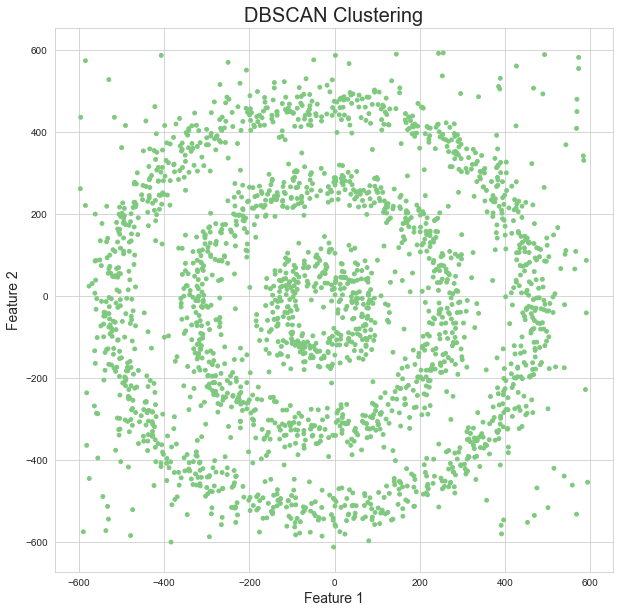

In [10]:
df['DBSCAN_labels']=dbscan.labels_ 

# Plotting resulting clusters
plt.figure(figsize=(10,10))
plt.scatter(df[0],df[1],c=df['DBSCAN_labels'],cmap='Accent',s=15)
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

From the visualization above, we can see that the DBSCAN algorithm classified all points into a single cluster. This is due to the fact that we did not optimize any parameters. To correctly classify points, we need to find the values of epsilon and minPoints parameters for DBSCAN algorithm.

For finding appropriate epsilon, we can use K-distance graph. For plotting K-distance graph, we need the distance between a point and its nearest data point for all data points in the dataset. We obtain this using NearestNeighbors from sklearn.neighbors.

In [11]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[[0,1]])
distances, indices = nbrs.kneighbors(df[[0,1]])

The distances variable contains an array of distances between a data point and its nearest data point for all data points in the dataset.

In [12]:
distances

array([[ 0.        ,  6.91861074],
       [ 0.        , 10.80836526],
       [ 0.        ,  7.56030267],
       ...,
       [ 0.        , 25.77071121],
       [ 0.        , 23.34523506],
       [ 0.        , 37.73592453]])

Let’s plot our K-distance graph and find the value of epsilon.

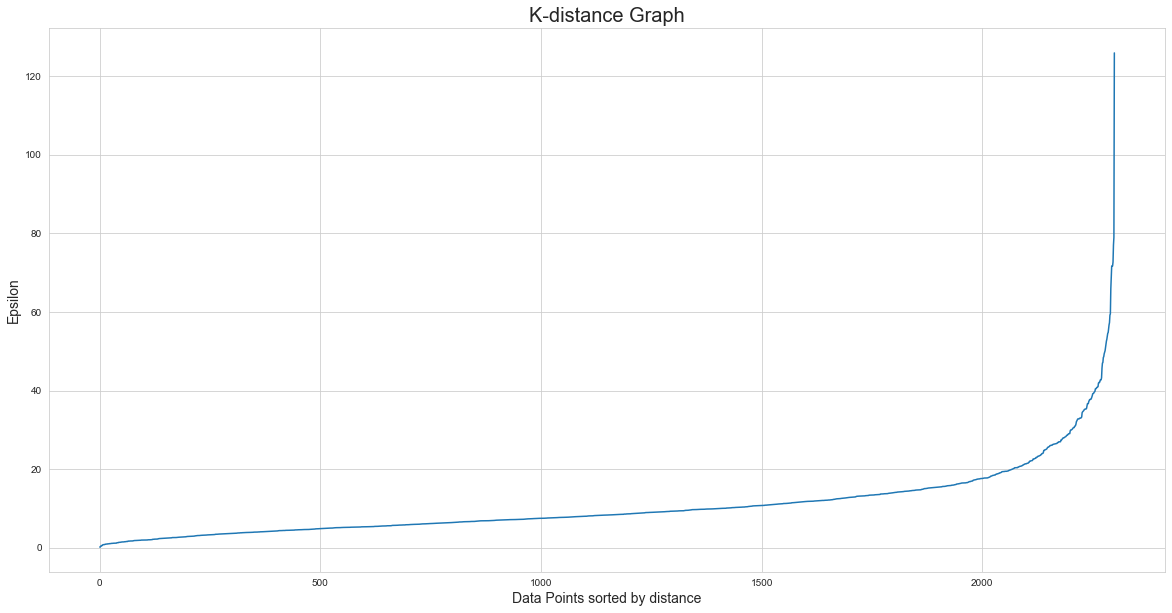

In [13]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

The optimum value of epsilon is at the point of maximum curvature in the K-Distance Graph, which is 30 in this case. Now, it’s time to find the value of minPoints. The value of minPoints also depends on domain knowledge. Here we are taking minPoints as 6:

In [14]:
from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=30,min_samples=6)
dbscan_opt.fit(df[[0,1]])

DBSCAN(eps=30, min_samples=6)

In [15]:
df['DBSCAN_opt_labels']=dbscan_opt.labels_
df['DBSCAN_opt_labels'].value_counts()

 0    1030
 1     730
 2     318
-1     222
Name: DBSCAN_opt_labels, dtype: int64

From the output above, we can see that there are 4 groups: 0, 1, 2 and -1. The intepretation is as follows:
1. 0, 1 and 2: the 3 cluster groups identified by the DBSCAN algorithm
2. -1: noise or outliers and not belong to any clusters

Notice that we did not specify how many clusters beforehand and DBSCAN is still able to figure it out.

Now, let's plot out the results.

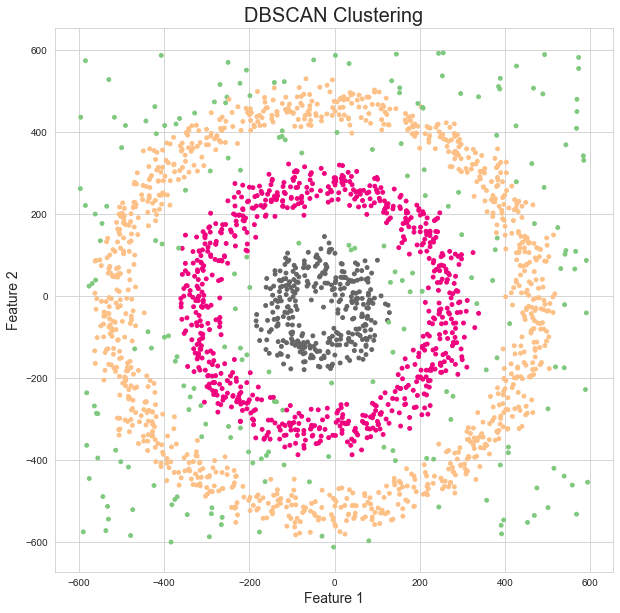

In [16]:
# Plotting the resulting clusters
plt.figure(figsize=(10,10))
plt.scatter(df[0],df[1],c=df['DBSCAN_opt_labels'],cmap='Accent',s=15)
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

As shown above, DBSCAN amazingly clustered the data points into three clusters, and it also detected noise in the dataset represented by the green color.

One important thing to note here is that, though DBSCAN creates clusters based on varying densities, it struggles with clusters of similar densities. In this case, using K-Means or Hierarchical clustering may be better off. Also, as the dimension of data increases, it becomes difficult for DBSCAN to create clusters and it falls prey to the Curse of Dimensionality.